In [1]:
pip install parsivar


  Using cached nltk-3.4.5-py3-none-any.whl
  Attempting uninstall: nltk
    Found existing installation: nltk 3.3
    Uninstalling nltk-3.3:
      Successfully uninstalled nltk-3.3
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hazm 0.7.0 requires nltk==3.3, but you have nltk 3.4.5 which is incompatible.


In [2]:
pip install hazm

  Using cached nltk-3.3-py3-none-any.whl
  Attempting uninstall: nltk
    Found existing installation: nltk 3.4.5
    Uninstalling nltk-3.4.5:
      Successfully uninstalled nltk-3.4.5
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
parsivar 0.2.3 requires nltk==3.4.5, but you have nltk 3.3 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import reshape

In [4]:
from parsivar import Normalizer
from parsivar import Tokenizer
from hazm import *

class Preprocessor:
    def __init__(self,data):
        self.dataframe = data
        
    
    def remove_stop_words(self,word_list):
        stop_words = set(open('stopwords.txt',encoding="utf8").read().split())
        words = []
        for word in word_list:
            if word[:-1] in stop_words:
                parts = word.split(word[:-1])
                word = parts[0]
            
           # if "#" in word: 
            #    parts = word.split("#")
             #   if len(parts) == 2:
              #      if parts[0] in stop_words or parts[1] in stop_words:
               #         word = ""
                #    else:
                 #       word = parts[0]+parts[1]
                    
            if word in stop_words:
                word = ""
            
            if word:
                word = word.replace(u"\u200c", "")
                if len(word) > 2:
                    words.append(word)
            
        return words
    
    def stemming(self,txt):
        return [Stemmer().stem(word) for word in txt]
    
    def lemmatization(self,txt):
        return [Lemmatizer().lemmatize(word) for word in txt]
       
    def get_token(self,txt):
        return Tokenizer().tokenize_words(txt)
   
    def Preprocess(self,colname):
        data = self.dataframe[colname]
        data = data.apply(Normalizer().normalize)
        data = data.apply(Tokenizer().tokenize_words)
        data = data.apply(self.stemming) 
       # data = data.apply(self.lemmatization) 
        data = data.apply(self.remove_stop_words)
        return data

In [5]:
import operator
from tqdm import tqdm

class Classifier:
    def __init__(self):
        self.words_dict = None 
        self.classes_count = {}
        self.classes_freq = {}
        self.total_words = 0
        self.targetCol = None
        self.inputCol = None
 
    def create_dict(self, df, input_col, target_col):
        dictionary = dict()
        for row_index in df.index:
            target_class = df[target_col][row_index]
            
            if target_class not in dictionary:
                dictionary[target_class] = dict()
                
            if target_class not in self.classes_count:
                self.classes_count[target_class] = 0
            
            if target_class not in self.classes_freq:
                self.classes_freq[target_class] = 0
                
            for word in df[input_col][row_index]:
                if word not in dictionary[target_class]:
                    dictionary[target_class][word] = 1
                else:
                    dictionary[target_class][word] += 1
                self.classes_count[target_class] += 1
                self.total_words += 1
            self.classes_freq[target_class] += 1
        self.words_dict = dictionary 
        #print("dict is ",dictionary[target_class])
    

    def train(self, train_df, input_col, target_col):
        self.create_dict(train_df, input_col, target_col)
        self.targetCol = target_col
        self.inputCol = input_col

    def predict(self, test_input, smoothing):
        class_scores = dict()
        classes = list(self.words_dict.keys())
        for target_class in classes:
            class_scores[target_class] = 1
            for word in test_input:
                if(smoothing):
                    targetClass_frequency = self.classes_freq[target_class] / sum(self.classes_freq.values())
                    prob = ((self.words_dict[target_class].get(word, 0)+1) / (self.classes_count[target_class]+1+self.total_words))*targetClass_frequency
                else:
                    targetClass_frequency = self.classes_freq[target_class] / sum(self.classes_freq.values())
                    prob = ((self.words_dict[target_class].get(word, 0)) / (self.classes_count[target_class]))*targetClass_frequency
                class_scores[target_class] += np.log(prob)
       # print("class score is ",class_scores)
        maxScore_class = max(class_scores.items(), key=operator.itemgetter(1))[0]
        return maxScore_class
    
    def applyClassification(self, test_df, input_col, smoothing):
        df = test_df
        results = []
        for row_index in tqdm(df.index):
            predicted_class = self.predict(df[input_col][row_index], smoothing)
            results.append(predicted_class)
        return results
    
    def top_words(self, n):
        best_words = dict()
        for c in list(self.words_dict.keys()):
            best_words[c] = dict(sorted(self.words_dict[c].items(), key=operator.itemgetter(1), reverse=True)[:n])
        return best_words



In [6]:
def plot_top_words(best_words):
    plt.figure(figsize=(15, 8))
    for i, c in enumerate(best_words):
        plt.subplot(2, 3, i+1)
        plt.gca().set_title(get_display(reshape(c)))
        plt.bar([get_display(reshape(label)) for label in best_words[c].keys()], best_words[c].values(), color='g')
    plt.show()

In [7]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
def evaluate(predictions, tests):
    classes = list(set(tests['label'].values))
    labels = tests["label"].to_list()
    true_preds= dict()
    false_preds = dict()
    true_count = 0
    false_count = 0
    for c in classes:
        true_preds[c] = 0
        false_preds[c] = 0
    for i in range(len(labels)):
        if predictions[i] == labels[i]:
            true_preds[predictions[i]] += 1
            true_count  += 1
        else:
            false_preds[predictions[i]] += 1
            false_count += 1
        
    cols = ['Precision', 'Recall','F1-score','Accuracy','Macro Avg','Micro Avg', 'Weighted Avg']
    result_df = pd.DataFrame(0, index = cols, columns = [classes[0], classes[1], classes[2],classes[3], 'All Classes'])
    for class_ in classes:
        result_df.loc['Precision' , class_] = ( predictions.count(class_)-false_preds[class_]) / predictions.count(class_)
        result_df.loc['Recall' , class_] = ( predictions.count(class_)-false_preds[class_]) / labels.count(class_)
        result_df.loc['F1-score' , class_] = (2*result_df.loc['Precision' , class_]*result_df.loc['Recall' , class_])/(result_df.loc['Recall' , class_]+result_df.loc['Precision' , class_])
        result_df.loc['Recall' , class_] = ( predictions.count(class_)-false_preds[class_]) / labels.count(class_)
    result_df.loc['Accuracy' , 'All Classes'] =  true_count /  (len(labels))

    result_df.loc['Macro Avg' , 'All Classes'] = ((result_df.loc['F1-score' , classes[0]] +  result_df.loc['F1-score' , classes[1]]+ result_df.loc['F1-score' , classes[2]]+ result_df.loc['F1-score' , classes[3]])/4)
    result_df.loc['Micro Avg' , 'All Classes'] =   true_count /  (len(labels))
    result_df.loc['Weighted Avg' , 'All Classes'] = ((result_df.loc['F1-score' , classes[0]]*labels.count(classes[0]) +  result_df.loc['F1-score' , classes[1]]*labels.count(classes[1])+ result_df.loc['F1-score' , classes[2]]*labels.count(classes[2])+ result_df.loc['F1-score' , classes[3]]*labels.count(classes[3])))/len(labels)
    
        
    display(result_df)

In [8]:
def get_false_positive_samples(n, preds,tests):
    test_df = load_DataSet('test.csv')
    labels = tests["label"].to_list()
    count = 0
    for i in range(len(labels)):
        if preds[i] != labels[i]:
            print("index is ",i)
            print("true label:", labels[i],"\n predicted label:", preds[i])
            print("initial content:\n", test_df["content"].to_list()[i])
            print("preprocessed content:\n", tests["content"].to_list()[i])
            count+=1
            if(count == n):
                break

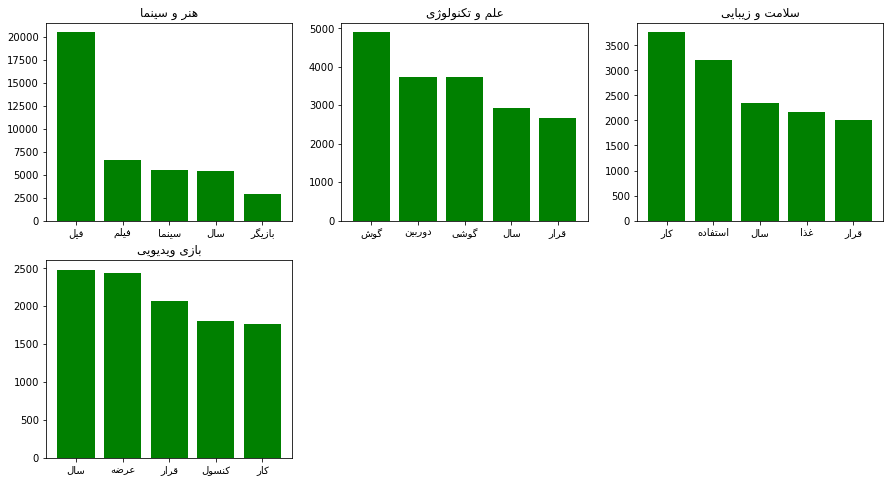

  0%|          | 0/802 [00:00<?, ?it/s]C:\Users\Saba\AppData\Local\Temp/ipykernel_15280/3318884508.py:56: RuntimeWarning: divide by zero encountered in log
  class_scores[target_class] += np.log(prob)
100%|██████████| 802/802 [00:01<00:00, 507.59it/s]

Naive Bayes without smoothing


,سلامت و زیبایی,بازی ویدیویی,علم و تکنولوژی,هنر و سینما,All Classes
Precision,0.888889,0.958333,0.941176,0.222074,0.000000
Recall,0.049689,0.116751,0.057762,1.000000,0.000000
F1-score,0.094118,0.208145,0.108844,0.363439,0.000000
Accuracy,0.000000,0.000000,0.000000,0.000000,0.266833
Macro Avg,0.000000,0.000000,0.000000,0.000000,0.193636
Micro Avg,0.000000,0.000000,0.000000,0.000000,0.266833
Weighted Avg,0.000000,0.000000,0.000000,0.000000,0.183293


100%|██████████| 802/802 [00:01<00:00, 538.60it/s]

Naive Bayes with smoothing


,سلامت و زیبایی,بازی ویدیویی,علم و تکنولوژی,هنر و سینما,All Classes
Precision,0.923077,0.994444,0.956679,0.943182,0.000000
Recall,0.968944,0.908629,0.956679,0.994012,0.000000
F1-score,0.945455,0.949602,0.956679,0.967930,0.000000
Accuracy,0.000000,0.000000,0.000000,0.000000,0.955112
Macro Avg,0.000000,0.000000,0.000000,0.000000,0.954916
Micro Avg,0.000000,0.000000,0.000000,0.000000,0.955112
Weighted Avg,0.000000,0.000000,0.000000,0.000000,0.955030


index is  40
true label: بازی ویدیویی 
 predicted label: هنر و سینما
initial content:
 مسترچیف شخصیت اصلی سریال Halo خواهد بود یکی دو ماه پیش بود بود که استودیوی سازنده مجموعه بازی‌های هیلو، یعنی استودیوی ۳۴۳ Industries اعلام کرد با همکاری شبکه‌های Amblin Television، شوتایم و البته تهیه کنندگی استیون اسپیلبرگ مشغول ساخت یک سریال تلویزیونی بر اساس بازی هیلو (Halo) هستند‌ در این بیانیه جدا از اعلام نام دست اندرکاران این پروژه و تاریخ شروع مراحل تولید این سریال (سال ۲۰۱۹)، اطلاعاتی هم درباره ماهیت آن ارایه شد‌ حالا شبکه شوتایم هم در کنفرانس مطبوعاتی خود اطلاعات بیشتری را از این مجموعه منتشر کرده است‌تولید سریال هیلو قرار است از سال آینده‌ی میلادی آغاز شود‌در این پنل مطبوعاتی، دیوید نوینز (مدیر شبکه شوتایم) و گری لوین (رئیس بخش برنامه‌ریزی شبکه شوتایم) حضور داشتند‌ وقتی از آن‌ها درباره احتمال حضور مسترچیف (شخصیت اصلی سری بازی‌های هیلو) سوال شد، هر دو آن‌ها تایید کردند که نه تنها این کاراکتر در این سریال حضور خواهد داشت، بلکه در واقع نقش اصلی و بسیار مهمی هم ایفا خواهد کرد. پس از آن، لوین ا

In [9]:
def load_DataSet(dataPath):
    dataframe =  pd.read_csv(dataPath)
    dataframe.dropna(subset = ['content'], inplace=True)
    return dataframe

if __name__ == "__main__":
    train_df = load_DataSet('train.csv')
    test_df = load_DataSet('test.csv')
    train_df['content'] = Preprocessor(train_df).Preprocess('content')
    test_df['content'] = Preprocessor(test_df).Preprocess('content')

    classifier = Classifier()
    classifier.train(train_df, 'content', 'label')
    
    plot_top_words(classifier.top_words(5))
    nonsmoothing_results = classifier.applyClassification(test_df, 'content', smoothing=0)
    print("Naive Bayes without smoothing")
    evaluate(nonsmoothing_results ,test_df)
    
    smoothing_results = classifier.applyClassification(test_df, 'content', smoothing=1)
    print("Naive Bayes with smoothing")
    evaluate(smoothing_results,test_df)
    
    
    get_false_positive_samples(5,smoothing_results,test_df)
